In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from __future__ import division  #needed for eval to divide fractions to float instead of integer default of Python v<3
from utils_read_parsing import *

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 10,4
CMAP = ['cornflowerblue','#fc8d62','#a6d854','#b3b3b3','#e78ac3','#66c2a5','#ffd92f']
matplotlib.rcParams['axes.color_cycle'] = CMAP
plt.style.use = 'default'
plt.rcParams['figure.figsize'] = (8, 6)
pd.options.display.max_columns = 999

C:\Users\sperez8\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Import data files

In [104]:
df_quant_ans = pd.read_csv('all_quant_answers_key.csv', delimiter=',')

In [2]:
posts = pd.read_csv('post_survey_results.txt', sep='\t')
posts.replace('Absorbance','L',inplace=True)
posts.replace('Capacitance','C',inplace=True)
filenameL_ans = 'postSurvey_L_answerKey.csv'
filenameC_ans = 'postSurvey_C_answerKey.csv'
dfL_ans_raw = pd.read_csv(filenameL_ans, delimiter='\t', encoding='utf-16')
dfC_ans_raw = pd.read_csv(filenameC_ans, delimiter='\t', encoding='utf-16')

In [3]:
posts

,Unnamed: 0,age,debug1,debug2,english.0-writing,english.1-reading,[gender] To which gender do you most identify? [Gender non conforming/non-binary],[gender] To which gender do you most identify? [Man],[gender] To which gender do you most identify? [Prefer not to answer],gender-Woman,original id,major,open1,open2,perceivedvalue.0-boring,perceivedvalue.1-productive,perceivedvalue.2-useless,perceivedvalue.3-engaging,pocc.0-learning the basic concepts,pocc.1-testing my ideas and theories,pocc.2-answering given questions,pocc.3-memorizing key information,pocc.4-exploring the topic,qual2,qual3,qual4,qual5,qual5reasoning,qual6,qual6reasoning,quant.0,quant.0.1,quant.1,quant.1.1,quant.2,quant.2.1,quant.3,quant.3.1,strategies.0-setup my first experiment right away,strategies.10-try to identify mathematical relationships,strategies.11-try to apply my prior knowledge of physics,strategies.12-predict the result of a test before trying something out,strategies.13-decide what to investigate based on previous results,strategies.14-identify what I haven't investigated yet,strategies.1-spend time designing a set of experiments I want to conduct,strategies.2-make a plan,strategies.3-explore the different components of the PhET interface,strategies.4-identify important variables,strategies.5-look for weird outcomes I did not expect,strategies.6-look for general patterns and then dive into detailed experimentation,strategies.7-check if the relationships I found hold under different conditions,strategies.8-think about why I get the results I get,strategies.9-summarize my findings as I go,strategies_att.0-try to get the right answer,strategies_att.1-improve my scientific reasoning skill,strategies_att.2-try to learn more about the topic,strategies_att.3-finish as quickly as possible,strategies_att.4-come up with my own questions to investigate,taskinterpretation.0-investigate the basic mechanics of the topic at hand,taskinterpretation.1-design my own experiments that can help me understand the topic at hand,taskinterpretation.2-memorize information about the topic at hand,taskinterpretation.3-complete a certain number of questions,taskinterpretation.4-develop scientific reasoning skills,[year] What year are you in? [1st year undergraduate],[year] What year are you in? [2nd year undergraduate],[year] What year are you in? [3rd year undergraduate],[year] What year are you in? [4th year undergraduate],sim,sim_index,qual1,sid
0,2,18-19,"Based on virtual lab results, the charge vs. p...",The negative should not be there because it on...,Fluent,Fluent,NaN,NaN,NaN,1.0,77047160,*Non science or applied science major,I conducted 4 different experiments where I va...,Graphs helped visualize the patterns. Next tim...,Somewhat,Mostly,Not at all,Mostly,Often,Almost always,Almost always,Often,Often,higher voltage battery (https://survey.ubc.ca/...,(https://survey.ubc.ca/media/assets/user/2316...,smaller separation (https://survey.ubc.ca/medi...,(https://survey.ubc.ca/media/assets/user/2316...,The magnitude of the voltage is increasing in ...,two large plates perfectly aligned (https://su...,The plates need to be aligned perfectly in ord...,NaN,0.5,NaN,0.25,NaN,2,NaN,08-Jan,Mostly,Definitely,Somewhat,Mostly,Mostly,Mostly,Mostly,Somewhat,Mostly,Somewhat,Definitely,Mostly,Definitely,Definitely,Definitely,Definitely,Mostly,Somewhat,Somewhat,Mostly,Mostly,Mostly,Somewhat,Mostly,Mostly,1.0,NaN,NaN,NaN,C,2,larger plates (https://survey.ubc.ca/media/ass...,77047160
1,3,20-22,"k1, k2, and k3 are unnecessary. There should b...","s^2 should be s, as Q is inversely proportiona...",Average,Fluent,NaN,1.0,NaN,NaN,90447168,*Undeclared,I tried to explore more different combinations...,I believe I managed to find all the possible o...,Not at all,Mostly,Not at all,Mostly,Almost always,Often,Almost always,Almost always,Often,higher voltage battery (https://survey.ubc.ca/...,(https://survey.ubc.ca/media/assets/user/2316...,smaller separation (https://survey.ubc.ca/medi...,(https://su

In [4]:
### Filter out only post-assessment data and rename columns

def filter_df( df, pattern, new_headers ):
    headers = list(df)
    filtered_headers = [header for header in headers if re.search(pattern, header)]
    df2 = df.loc[:, filtered_headers]  
    newcolnames = {header : new_header for (header, new_header) in zip(filtered_headers, new_headers)}
    df2.rename(columns=newcolnames, inplace=True)
    return df2

#pick out only column that match student ID, qual or quant questions
other_pattern = '\[id\]'
qual_pattern = '\[qual[0-9]\]'
quant_pattern = '\[quant\.[0-9]'  #specify number in regex only needed in case we only want certain specific Qs
pattern = other_pattern + '|' + qual_pattern + '|' + quant_pattern

#pick out new names for the columns that will be picked from above patterns
other_colnames = ['id']
qual_colnames = ['qual1','qual2','qual3','qual4','qual5','qual6']
quant_colnames = ['quant1','quant2','quant3','quant4']
colnames = other_colnames + qual_colnames + quant_colnames

# #filter and rename capacitor dataframe
# dfC_LC = filter_df( dfC_LC_raw, pattern, colnames )
# dfC_LC.loc[:,'condition'] = pd.Series('LC', index=dfC_LC.index) #add column for condition i.e. if C was first or last
# dfC_CL = filter_df( dfC_CL_raw, pattern, colnames )
# dfC_CL.loc[:,'condition'] = pd.Series('CL', index=dfC_CL.index)
# dfC = pd.concat([dfC_LC, dfC_CL], ignore_index=True)
# # dfC=dfC.set_index('id')  #this is for setting ID as row index
# # dfC.index.name = None
# print dfC.shape

# #filter and rename light absorbance dataframe
# dfL_LC = filter_df( dfL_LC_raw, pattern, colnames )
# dfL_LC.loc[:,'condition'] = pd.Series('LC', index=dfL_LC.index) #add column for condition i.e. if L was first or last
# dfL_CL = filter_df( dfL_CL_raw, pattern, colnames )
# dfL_CL.loc[:,'condition'] = pd.Series('CL', index=dfL_CL.index)
# dfL = pd.concat([dfL_LC, dfL_CL], ignore_index=True)
# # dfL=dfL.set_index('id')  #this is for setting ID as row index
# # dfL.index.name = None
# print dfL.shape

#filter and rename answer key dataframes
dfC_quant_ans = filter_df( dfC_ans_raw, quant_pattern, quant_colnames )
dfC_qual_ans = filter_df( dfC_ans_raw, qual_pattern, qual_colnames )
dfC_ans = pd.concat([dfC_qual_ans, dfC_quant_ans], axis=1)
print dfC_ans.shape

dfL_quant_ans = filter_df( dfL_ans_raw, quant_pattern, quant_colnames )
dfL_qual_ans = filter_df( dfL_ans_raw, qual_pattern, qual_colnames )
dfL_ans = pd.concat([dfL_qual_ans, dfL_quant_ans], axis=1)
print dfL_ans.shape


# # df.dtypes  #find what type is each column
# # # find bad student IDs to fix  
# # # need to check validity of ID --> needs to start with one, or too few characters needs to be checked.
# # print set(dfC['id'])-set(dfL['id']) 
# # print set(dfL['id'])-set(dfC['id'])
# # # this finds duplicate entries
# IDcounts = Counter(list(dfL['id']))
# duplicates=[ID for ID in IDcounts if IDcounts[ID]>1]
# # dfL[ dfL['id'] == duplicates ]  #examine duplicates
# # dfL.set_value(73, 'id', 23784336) #change ID for one of the duplicates assuming different dates.
# dfL = dfL[ dfL['id'] != duplicates ] #remove duplicates
# # dfL.reset_index(level=0, drop=True)
# dfC = dfC[ dfC['id'] != duplicates ] #remove duplicates
# # dfC.reset_index(level=0, drop=True) #reset index after dropping duplicates
# #dfL.drop_duplicates(...)  could also use this method

# # # merge C and L results in one dataframe
# # df = pd.merge(dfC, dfL, on=['id','condition'], how='outer', suffixes=('_C', '_L'))
# # # move condition column before data results
# # cols = list(df)
# # cols.remove('condition')
# # cols.insert(1, 'condition')
# # df = df[cols]
# # df['id'] = df['id'].astype(int) # <-- this shouldn't be needed but check!
# # # create new column for bad IDs that were fixed so that we can track with sim + handouts
# # # df.loc[:,'id_flag'] = pd.Series(0, index=df.index)
# # # for student in flag_student_IDs:
# # #     df[df['id']==student]['id_flag']=1 



(1, 10)
(1, 10)


In [5]:
# def create_year_column( df, years ):
#     headers = list(df)
#     for year in years:  #this is ugly/slow must be a better way 
#         for header in headers:
#             if re.search('\[year\].*' + year, header):
#                 idx = df[ df[header] == 1 ].index.tolist()
#                 df.set_value(idx, 'year', year)
        
# years = ['1','2','3','4','5','6','Mast','Doct']

# #pick out only column that match student ID, qual or quant questions
# some_pattern = '\[major\]|\[year\]'

# #pick out new names for the columns that will be picked from above patterns
# year_colnames = ['[year] ' + year for year in years]
# some_colnames = ['major'] + year_colnames
# df_demo = filter_df( dfL_CL_raw, some_pattern, some_colnames )
# create_year_column( df_demo, years )
# df_demo

In [6]:
# def what_is_year ( row, *years ):
#     cols = row.index
#     for year, col in zip(years, cols):
#         if row[col]==1:
#             return year

# df_demo2 = filter_df( dfL_CL_raw, some_pattern, some_colnames )
# df_demo2.loc[:,'year'] = df_demo2[ year_colnames ].apply(what_is_year, axis=1, args=years)
# df_demo2

### Grade qual questions

In [7]:
#create grading function for qualitative Qs
def grade_qual_questions( df, df_ans, sim, questions, id_col, ReportWrong = False ):
    students = df[id_col]
    print questions
    for student in students:
        for question in questions:
            idx = df[(df[id_col]==student)&(df['sim']==sim)].index.tolist()[0]
            if df.loc[idx][question] == df_ans.loc[0][question]:
                df.set_value(idx, question + '_' + sim + '_score', 1)
            else:
                df.set_value(idx, question + '_' + sim + '_score', 0)
                if ReportWrong:
                    print question, student
                    print df[df['id']==student][question].values
                    print df_ans[question].values, '\n'

grade_qual_questions(posts, dfL_ans, 'L', qual_colnames, 'sid' )
grade_qual_questions(posts, dfC_ans, 'C', qual_colnames, 'sid' )

['qual1', 'qual2', 'qual3', 'qual4', 'qual5', 'qual6']
['qual1', 'qual2', 'qual3', 'qual4', 'qual5', 'qual6']


In [8]:
#We can rename questions given what we know about them
new_col_names = {'qual1_L_score':'qual1_L_near_concentration',
             'qual2_L_score':'qual2_L_far_volume',
             'qual3_L_score':'qual3_L_near_width',
             'qual4_L_score':'qual4_L_near_detector',
             'qual5_L_score':'qual5_L_far_laserangle',
             'qual6_L_score':'qual6_L_near_wavelength',
             'qual1_C_score':'qual1_C_near_area',
             'qual2_C_score':'qual2_C_near_voltage',
             'qual3_C_score':'qual3_C_far_areazerovoltage',
             'qual4_C_score':'qual4_C_near_separation',
             'qual5_C_score':'qual5_C_near_polarvoltage',
             'qual6_C_score':'qual6_C_far_offset'}

posts.rename(index=str,columns=new_col_names,inplace=True)

In [9]:
qual_score_columns = ['qual1_L_near_concentration', #near transfer absorbance
                      'qual3_L_near_width',
                      'qual4_L_near_detector',
                      'qual6_L_near_wavelength',
                      #
                      'qual4_C_near_separation', #near transfer capacitance
                      'qual1_C_near_area',
                      'qual2_C_near_voltage',
                      'qual5_C_near_polarvoltage',
                      #
                      'qual5_L_far_laserangle', #far transfer
                      'qual2_L_far_volume',
                      'qual3_C_far_areazerovoltage',
                      'qual6_C_far_offset']
qual_scores = pd.concat([posts[[col for col in qual_score_columns if 'L' in col]].dropna().reset_index(drop=True),posts[[col for col in qual_score_columns if 'C' in col]].dropna().reset_index(drop=True)],axis=1)
qual_scores.head()

,qual1_L_near_concentration,qual3_L_near_width,qual4_L_near_detector,qual6_L_near_wavelength,qual5_L_far_laserangle,qual2_L_far_volume,qual4_C_near_separation,qual1_C_near_area,qual2_C_near_voltage,qual5_C_near_polarvoltage,qual3_C_far_areazerovoltage,qual6_C_far_offset
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


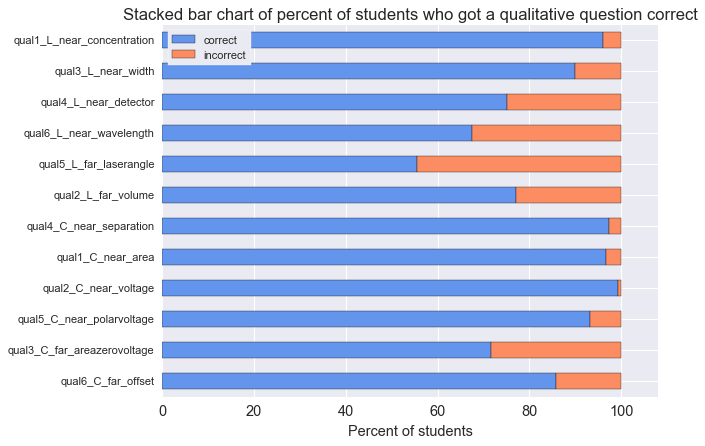

In [10]:
qual_scores.apply(lambda x: x.value_counts()).transpose().iloc[::-1,:].plot.barh(stacked=True)
ax = plt.subplot()
ax.legend(loc=2,frameon=True,labels=['correct','incorrect']);ax.set_xlabel('Percent of students',fontsize=13)
ax.set_xticklabels([0,20,40,60,80,100],fontsize=13)
ax.set_xticks([round(int(x)*148.0/100.0,1) for x in [0,20,40,60,80,100]])
ax.set_title("Stacked bar chart of percent of students who got a qualitative question correct",fontsize=15);

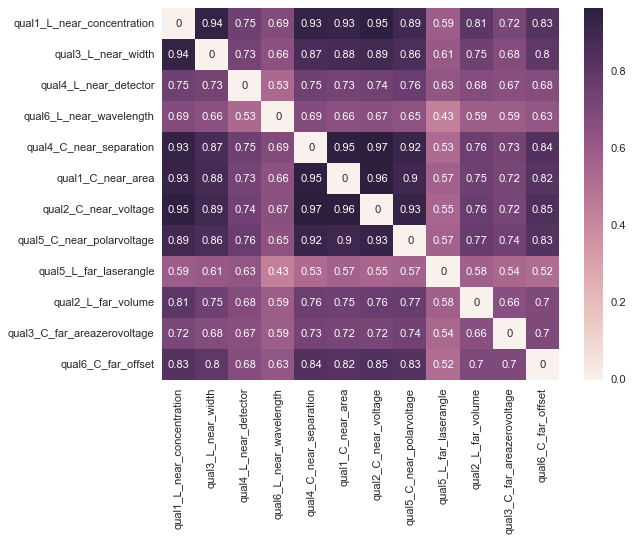

In [11]:
from scipy.stats import spearmanr
from sklearn.metrics import jaccard_similarity_score
correlation_matrix = np.zeros((len(qual_score_columns),len(qual_score_columns)))
for i,qual_scores_i in enumerate(qual_score_columns):
    for j,qual_scores_j in enumerate(qual_score_columns):
        jc = jaccard_similarity_score(list(qual_scores[qual_scores_i].dropna().astype(int)),list(qual_scores[qual_scores_j].dropna().astype(int)))
        correlation_matrix[i,j] = jc
#         print att_i,att_j,r,p

np.fill_diagonal(correlation_matrix,0)
# correlation_matrix[(correlation_matrix<0.4)&(correlation_matrix>-0.4)] = 0
sns.heatmap(correlation_matrix,yticklabels=qual_score_columns,xticklabels=qual_score_columns,annot=True);

In [32]:
from scipy.stats import pearsonr
def cronbach_alpha(scores):
    K = scores.shape[1]
    sum_of_var = scores.apply(lambda x: np.var(x), axis=0).sum()
    var = np.var(scores.sum(axis=1))
    alpha = (K/(K-1))*(1-sum_of_var/var)
    return round(alpha,1)

def spearman_brown_coef(scores):
    ''' Use for reliability of two item scale
    https://link.springer.com/content/pdf/10.1007/s00038-012-0416-3.pdf
    '''
    r,p = pearsonr(scores.ix[:,0],scores.ix[:,1])
    coef = 2*r/(1+r)
    return round(coef,1)

print 'all (12)',cronbach_alpha(qual_scores)
print 'near variables (4)',cronbach_alpha(qual_scores[['qual1_L_near_concentration','qual3_L_near_width','qual4_C_near_separation','qual1_C_near_area']])
print 'near not variables (4)',cronbach_alpha(qual_scores[['qual4_L_near_detector','qual6_L_near_wavelength','qual2_C_near_voltage','qual5_C_near_polarvoltage']])
print 'near absorbance (4)',cronbach_alpha(qual_scores[['qual4_L_near_detector','qual6_L_near_wavelength','qual1_L_near_concentration','qual3_L_near_width']])
print 'near capacitance (4)',cronbach_alpha(qual_scores[['qual4_C_near_separation','qual1_C_near_area','qual2_C_near_voltage','qual5_C_near_polarvoltage']])
print 'near all (8)',cronbach_alpha(qual_scores[['qual1_L_near_concentration','qual3_L_near_width','qual4_C_near_separation','qual1_C_near_area','qual4_L_near_detector','qual6_L_near_wavelength','qual2_C_near_voltage','qual5_C_near_polarvoltage']])
print 'far all (4)',cronbach_alpha(qual_scores[['qual5_L_far_laserangle','qual2_L_far_volume','qual3_C_far_areazerovoltage','qual6_C_far_offset']])

print 'near variable absorbance (2)', jaccard_similarity_score(qual_scores['qual1_L_near_concentration'],qual_scores['qual3_L_near_width'])
print 'near variable capacitance (2)', jaccard_similarity_score(qual_scores['qual4_C_near_separation'],qual_scores['qual1_C_near_area'])
print 'far variable absorbance (2)', jaccard_similarity_score(qual_scores['qual5_L_far_laserangle'],qual_scores['qual2_L_far_volume'])
print 'far variable capacitance (2)', jaccard_similarity_score(qual_scores['qual3_C_far_areazerovoltage'],qual_scores['qual6_C_far_offset'])

 all (12) 0.4
near variables (4) 0.4
near not variables (4) -0.1
near absorbance (4) 0.2
near capacitance (4) 0.1
near all (8) 0.3
far all (4) 0.2
near variable absorbance (2) 0.939189189189
near variable capacitance (2) 0.952702702703
far variable absorbance (2) 0.581081081081
far variable capacitance (2) 0.695945945946


### Grade quant questions

In [105]:
# #create grading function for quant Qs
# def is_number( string ):
#     try:
#         float( eval( re.sub('[pPcC]', '', string) )) #this evaluates fractions and strips units
#         return True
#     except:
#         return False

# def make_number( string ):
#     return float( eval( re.sub('[pPcC]', '', string) ))

def grade_quant_questions( df, df_ans, sim, questions,  id_header ):
    students = df[id_header]
    for question in questions:
        for student in students:
            idx = df[(df[id_header]==student)&(df['sim']==sim)].index.tolist()[0]
            student_ans = df.loc[idx][question]
            try:
                score = df_ans.get_value(df_ans[(df_ans['answer']==student_ans)&(df_ans['question']==question)&(df_ans['sim']==sim)].index.tolist()[0],'score')
                df.set_value(idx, question + '_score', score)
            except:
                print student, student_ans, question
grade_quant_questions(posts, df_quant_ans, 'L', ['quant.0','quant.1','quant.2','quant.3'], 'sid')
grade_quant_questions(posts, df_quant_ans, 'C', ['quant.0.1','quant.1.1','quant.2.1','quant.3.1'], 'sid')

59043165 02-Jan quant.0.1
59043165 02-Jan quant.0.1
51717164 02-Jan quant.0.1
51717164 02-Jan quant.0.1
59043165 02-Jan quant.1.1
59043165 02-Jan quant.1.1
51717164 02-Jan quant.1.1
51717164 02-Jan quant.1.1
17576140 08-Jan quant.2.1
17576140 08-Jan quant.2.1
77047160 08-Jan quant.3.1
59043165 04-Jan quant.3.1
77047160 08-Jan quant.3.1
59043165 04-Jan quant.3.1
51717164 04-Jan quant.3.1
51717164 04-Jan quant.3.1


In [ ]:
posts[posts['sim']=='L'][[c for c in posts.columns if 'score' in c]].hist()

condition
CL    Axes(0.125,0.125;0.775x0.775)
LC    Axes(0.125,0.125;0.775x0.775)
Name: quant1_score, dtype: object

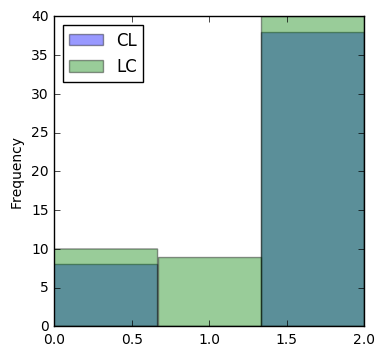

In [93]:
# print(dfL.describe())  #basic descriptive stats for each column
# dfL.hist(bins=3)  #plots set of histograms for all columns
# dfL.groupby('condition').hist(bins=3)  #plots 2 sets of histograms of each column, one set for each condition
# histogram of one column grouped by condition and overlayed
dfL.groupby('condition').quant1_score.plot.hist(bins=3,alpha=0.4,legend=True)  
# dfL.groupby('condition').count()
# dfL.groupby('condition').transform(lambda x: x / x.count())  #useful snippet to manipulate column data per condition

# making histograms directly using numpy/matplotlib for full control, e.g. normalizing frequency so to sum=1
# x1 = dfL[dfL['condition']=='CL']['quant1_score']
# x2 = dfL[dfL['condition']=='LC']['quant1_score']
# hist1, bins1 = np.histogram(x1, bins=3)
# hist2, bins2 = np.histogram(x2, bins=3)
# plt.bar(bins1[:-1], hist1 / hist1.sum(), width=(bins1[1]-bins1[0]), color='red',alpha=0.5, label='CL')
# plt.bar(bins2[:-1], hist2 / hist2.sum(), width=(bins2[1]-bins2[0]), color='blue',alpha=0.5, label='LC')
# plt.legend(loc='upper left')